# Petals to the metal

## Exploration Data Set

Kaggle link: https://www.kaggle.com/c/tpu-getting-started

### Main Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import re

In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers,initializers

In [3]:
tf.__version__

'2.2.0'

### General Settings

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Number of replicas: 1


In [5]:
AUTO = tf.data.experimental.AUTOTUNE
GCS_DS_Path = 'tpu-getting-started'
IMAGE_SIZE = [224,224]
GCS_PATH = GCS_DS_Path + '/tfrecords-jpeg-224x224'

In [6]:
training_file = tf.io.gfile.glob(GCS_PATH+'/train/*.tfrec') 
test_file = tf.io.gfile.glob(GCS_PATH+'/test/*.tfrec')
valid_file = tf.io.gfile.glob(GCS_PATH+'/val/*.tfrec')

In [7]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']  

### Functions to open to read the data

In [8]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [24]:
def get_training_dataset():
    dataset = load_dataset(training_file, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    #dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(valid_file, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(test_file, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [25]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

### Testing reading

In [26]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

In [27]:
print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
Training data label examples: [ 62   7  22  83  53   0   8  67  10  67  28 102  85   4   1   4]


In [28]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U'))

Test data shapes:
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
Test data IDs: ['94d32655a' '2fafd906d' 'c8bec0f66' '41ab6b40a' '7acc72b45' 'ac6d42eca'
 '8d8f3ee47' '4e5e899bd' '33a504d5d' 'eb86fad74' '06291a920' 'efa3cd848'
 '3231f45f3' 'c476f6495' '7a7fefad9' '954d0fe63']


In [29]:
def launch_image_sample(data):
    batches = next(iter(data.take(1)))

    fig,axes  = plt.subplots(nrows=4, ncols=4,figsize=(18.5,10))
    i=0
    for column in np.arange(4):
        for row in np.arange(4):
            image = batches[0][i]
            labelId = batches[1][i]
            axes[row,column].imshow(image,aspect='auto')
            axes[row,column].title.set_text(CLASSES[labelId])
            i+=1
    plt.suptitle('Sample of pictures',size='15')
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)

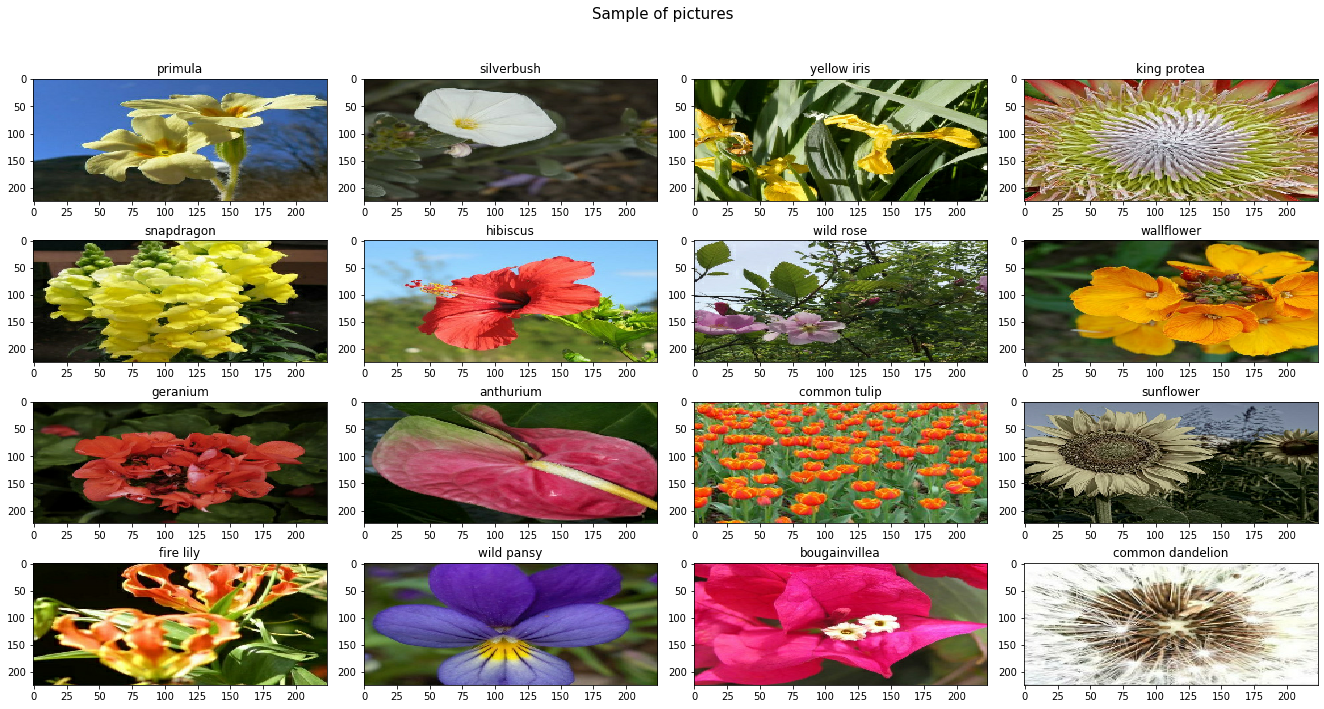

In [30]:
launch_image_sample(data = ds_train)

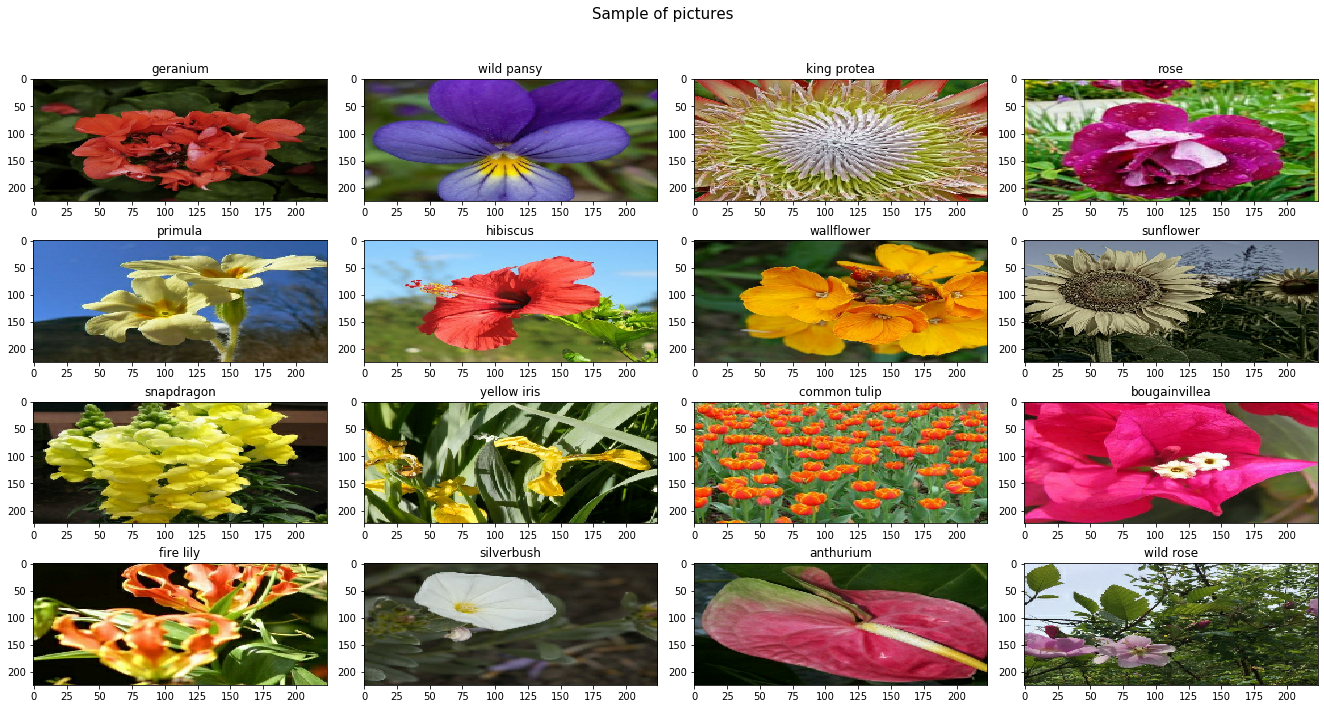

In [31]:
launch_image_sample(data = ds_train)

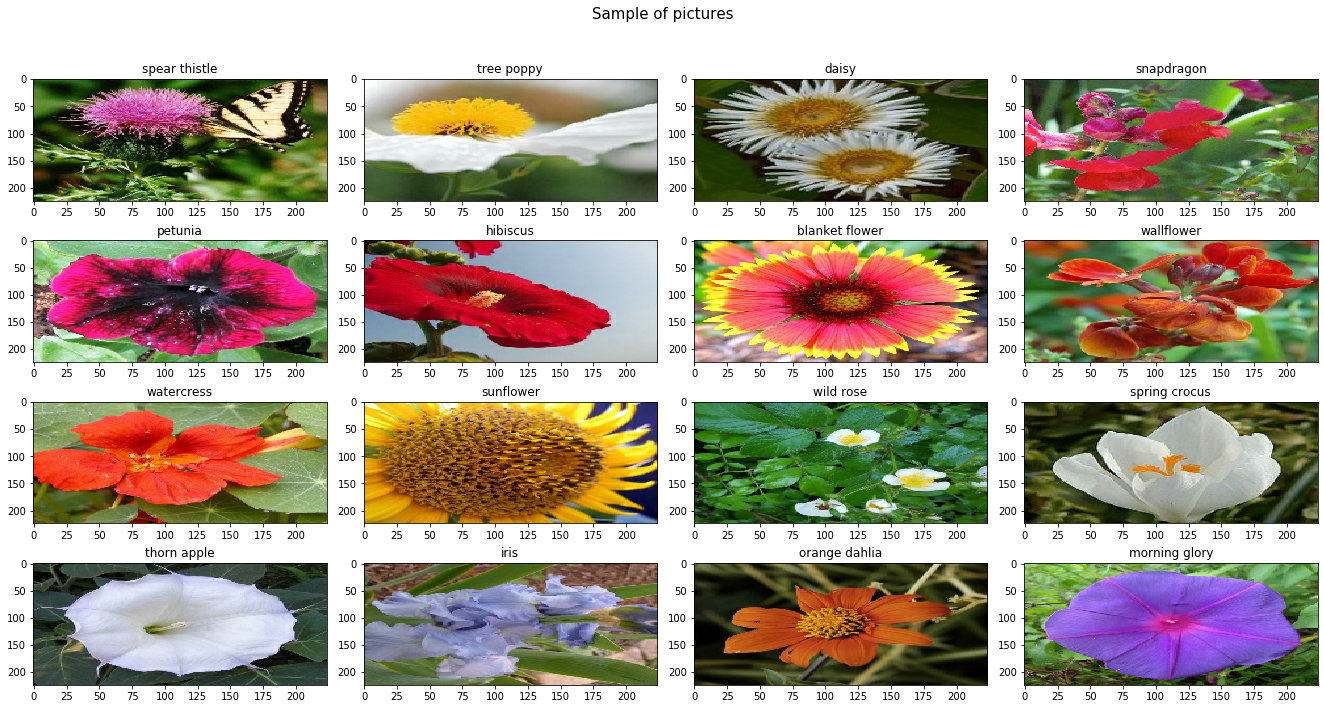

In [32]:
launch_image_sample(data = ds_valid)

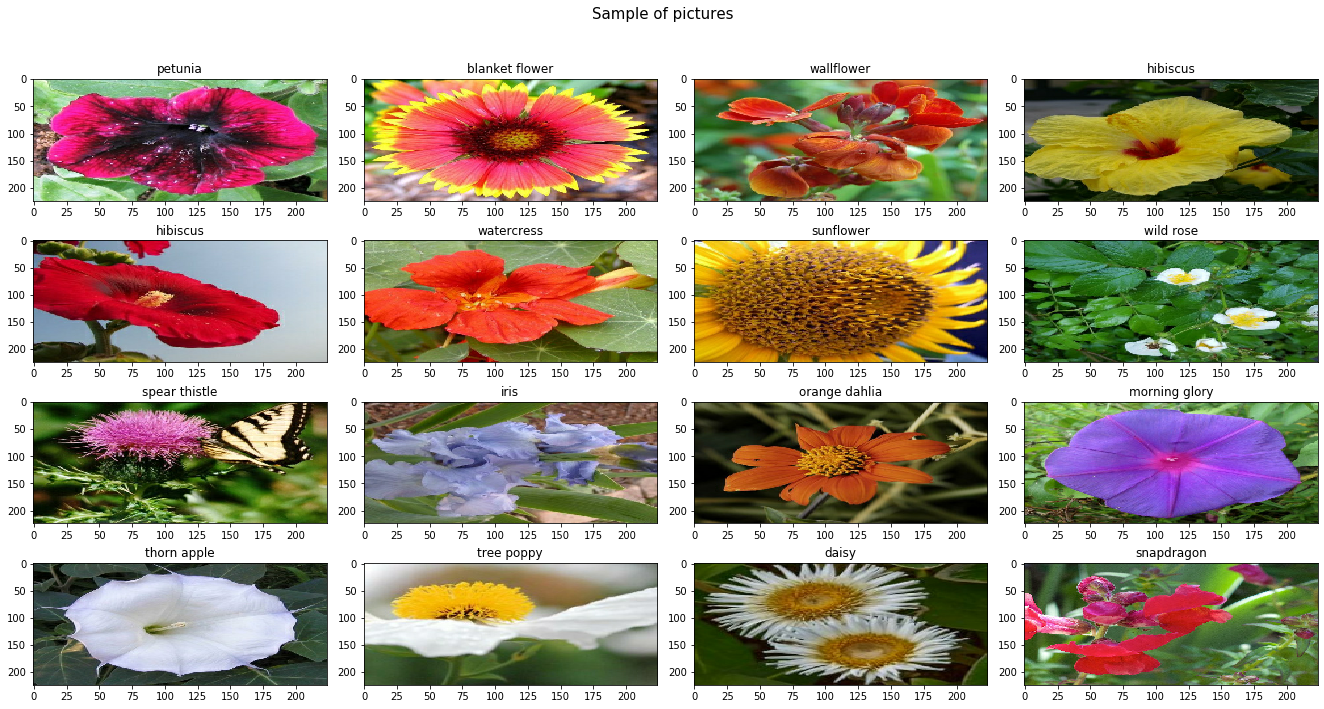

In [33]:
launch_image_sample(data = ds_valid)

In [34]:
NUM_TRAINING_IMAGES = count_data_items(training_file)
NUM_VALID_IMAGES = count_data_items(valid_file)
NUM_TEST_IMAGES = count_data_items(test_file)

print(f'the training sample is: {NUM_TRAINING_IMAGES}')
print(f'the validation sample is: {NUM_VALID_IMAGES}')
print(f'the test sample is: {NUM_TEST_IMAGES}')

the training sample is: 12753
the validation sample is: 3712
the test sample is: 7382


Visual Analysis:
* Zommed images
* WIth background
* multiple flower in one pic
* partial flower
* Angled 
* it seems that there is miss class data

### Model

In [47]:
def conv_block(X, filters, kernel_size, strides, pool_size):
    block = ZeroPadding2D(padding=4)(X)
    block = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides)(block)
    block = BatchNormalization(axis = 3)(block)
    block = Activation('relu')(block)
    if pool_size is not None:
        block = AveragePooling2D(pool_size = pool_size)(block)
    return block

In [48]:
def dense_block(X, Nodes, activation, dropout):
    block = Dense(Nodes, activation=activation,kernel_initializer=initializers.RandomNormal(stddev=0.15,mean=0.50)
                 ,bias_initializer=initializers.RandomNormal(stddev=0.05,mean=0.70))(X)
    if dropout is not None:
        block = Dropout(rate = dropout)(block)
    return block

In [49]:
def simple_model(input_shape):
    X_input = Input(input_shape)
    X = conv_block(X = X_input, filters = 10, kernel_size = (10, 10), strides = (3, 3), pool_size = None)
    X = conv_block(X = X, filters = 10, kernel_size = (10, 10), strides = (3, 3), pool_size = (2, 2))
    X = conv_block(X = X, filters = 10, kernel_size = (10, 10), strides = (3, 3), pool_size = None)
    
    X = Flatten()(X)
    
    X = dense_block(X = X, Nodes = 50, activation = 'relu', dropout = 0.25)
    X = dense_block(X = X, Nodes = 50, activation = 'relu', dropout = 0.25)
    
    X = Dense(len(CLASSES), activation='softmax', name = 'output_layer')(X)
    
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    return model

In [50]:
# Define training epochs
EPOCHS = 50
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

model = simple_model(input_shape=[*IMAGE_SIZE, 3])

opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "HappyModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 232, 232, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 10)        3010      
_________________________________________________________________
batch_normalization_8 (Batch (None, 75, 75, 10)        40        
_________________________________________________________________
activation_8 (Activation)    (None, 75, 75, 10)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 83, 83, 10)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 10)        1

In [ ]:
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    ##validation_split=0.35,
    validation_data = ds_valid,
    batch_size=100,
    shuffle=True,
    steps_per_epoch=STEPS_PER_EPOCH,
    verbose = 1)

model.metrics_names

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined